# 2D jet data

In this tutorial we will explore a small dataset provided with this package that contains pressure data of the flow exiting a nozzle (also referred to as a jet). In particular, we want to identify whether the data contains spatio-temporal coherent structures.

## Loading and configuring data

The dataset is part of the data used for the regression tests that come with this library and is stored into `tests/data/fluidmechanic_data.mat`. The first step to anlyze this dataset is to import the required libraries, including the custom libraries 
- `from pyspod.spod_low_storage import SPOD_low_storage`
- `from pyspod.spod_low_ram     import SPOD_low_ram`
- `from pyspod.spod_streaming   import SPOD_streaming`

that contain three different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines), and the third being a streaming algorithm, that required little amount of memory (both storage and RAM) but runs typically slower than the other two.

Note that we also import the custom library 
- `import library.weights as weights`

that implements the various weight matrices that might be required when performing SPOD. 

In [3]:
import os
import sys
import time
import h5py
import warnings
import xarray as xr
import numpy  as np
from pathlib import Path

# Import library specific modules
sys.path.append("../../../")
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
from pyspod.spod_streaming   import SPOD_streaming
import pyspod.weights as weights

# Current path
CWD = os.getcwd()

We then need to load the data from the `.mat` file and inspect it:

In [8]:
# Inspect and load data 
file = os.path.join(CWD,'../../../tests/data/fluidmechanic_data.mat')
variables = ['p']
with h5py.File(file, 'r') as f:
	data_arrays = dict()
	for k, v in f.items():
		data_arrays[k] = np.array(v)
dt = data_arrays['dt'][0,0]
block_dimension = 64 * dt
t = dt * np.arange(0,X.shape[0]); t = t.T
x1 = data_arrays['r'].T; x1 = x1[:,0]
x2 = data_arrays['x'].T; x2 = x2[0,:]
X = data_arrays[variables[0]].T

print('t.shape  = ', t.shape)
print('x1.shape = ', x1.shape)
print('x2.shape = ', x2.shape)
print('X.shape  = ', X.shape)

t.shape  =  (1000,)
x1.shape =  (20,)
x2.shape =  (88,)
X.shape  =  (1000, 20, 88)


the `mat` file contains **3 coordinates**:
- r, (radial coordinate)
- x, (axial coordinate) 
- time, 

along with **6 variables**:

- p (pressure).

In order for the data matrix `X` to be suitable to the `PySPOD` library the
- first dimension must correspond to the number of time snapshots (1000 in our case)
- last dimension should corresponds to the number of variables (1 in our case)
- the remaining dimensions corresponds to the spatial dimensions (20, and 88 in our case, that correspond to radial and axial spatial coordinates).

We note that the data matrix `X` used is already in a shape that is suitable to `PySPOD`, as its dimension is:

$$\text{$X$ dimensions} = 1000 \times 20 \times 88 $$

## Setting required and optional parameters

Once our data is in a shape suitable to the `PySPOD` library, we define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `dt`: time-sampling of the data (for now this must be constant)
- `nt`: number of time snapshots
- `xdim`: number of spatial dimensions
- `nv`: number of variables
- `n_FFT`: length of FFT blocks
- `n_freq`: number of frequencies
- `n_overlap`: dimension of the overlap region between adjacent blocks
- `mean`: type of mean to be subtracted from the data
- `normalize`: data normalization by data variance
- `savedir`: where to save the data
- `weights`: weights to be used to compute the inner product

The optional parameters are as follows:
- `savefreqs`: number of frequencies to be saved
- `n_modes_save`: number of modes to be saved
- `normavar`: normalize data by variance
- `conf_level`: calculate confidence level of modes
- `savefft`: save FFT blocks to reuse them in the future (to save time)


<font color='green'> **Note: we set the weights equal to a vector of ones, that must have the dimension of the flattened array along the spatial axes multiplied by the number of variables, that is:**
    
$$\textsf{weights dim} = \textsf{number of spatial points} \times \textsf{number of variables}$$. </font>

In [13]:
# define required and optional parameters
params = dict()

# required parameters
overlap_in_percent = 50
params['dt'          ] = dt              # data time-sampling
params['nt'          ] = t.shape[0]      # number of time snapshots
params['xdim'        ] = 2               # number of spatial dimensions (longitude and latitude)
params['nv'          ] = len(variables)  # number of variables
params['n_FFT'       ] = np.ceil(block_dimension / dt)     # length of FFT blocks
params['n_freq'      ] = params['n_FFT'] / 2 + 1           # number of frequencies 
params['n_overlap'   ] = np.ceil(params['n_FFT'] * overlap_in_percent / 100) # dimension block overlap region
params['mean'        ] = 'blockwise'  # type of mean to subtract to the data
params['normalize'   ] = False        # normalization of weights by data variance 
params['savedir'     ] = os.path.join(CWD, 'results', Path(file).stem) # folder where to save results
params['weights'] = np.ones([x1.shape[0]*x2.shape[0]*params['nv']])

# optional parameters
params['savefreqs'   ] = np.arange(0,params['n_freq']) # frequencies to be saved
params['n_modes_save'] = 3      # modes to be saved
params['normvar'     ] = False  # normalize data by data variance
params['conf_level'  ] = 0.95   # calculate confidence level
params['savefft'     ] = False  # save FFT blocks to reuse them in the future (saves time)

## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `SPOD_low_storage(X=X, params=params, file_handler=False)` and the `fit` method, `SPOD_analysis.fit()`. 

The `PySPOD` constructor takes the data `X`, the parameters `params` and a flag called `file_handler` as arguments. 
- The data `X` must be of dimensions (number of time snapshots, number of spatial dimensions, number of variables). 
- The parameters `params` must be a dictionary and contains the parameters that we have just defined. 
- The flag `file_handler` must be a boolean and indicates whether we intend to read each data stream sequentially, or we are passing the entire data block already loaded in RAM (the former is slower, but requires less RAM, the latter is faster but require more RAM).

The `fit()` method returns a `PySPOD` object containg the results. 

In [14]:
# Perform SPOD analysis using low storage module
SPOD_analysis = SPOD_low_storage(X=X, params=params, file_handler=False)
spod = SPOD_analysis.fit()

computing frequencies:   0%|          | 0/33 [00:00<?, ?it/s]


SPOD parameters
------------------------------------
Spectrum type             : one-sided (real-valued signal)
No. of snaphots per block :  64
Block overlap             :  32
No. of blocks             :  30
Windowing fct. (time)     :  hamming
Weighting fct. (space)    :  user-specified
Mean                      :  blockwise
Time-step                 :  0.2
Number of Frequencies     :  33
------------------------------------

DATA MATRIX DIMENSIONS
------------------------------------
Problem size          :  0.013113021850585958 GB. (double)
data matrix dimensions:         (1000, 20, 88, 1)
Make sure that first column of data matrix is time and last column is number of variables. 
First column dimension: 1000 must correspond to number of time snapshots.
Last column dimension: 1 must correspond to number of variables.
------------------------------------
 
Calculating temporal DFT (low_storage)
--------------------------------------
Checking if blocks are already present ...
... bloc

computing frequencies: 100%|██████████| 33/33 [00:00<00:00, 223.51it/s]

--------------------------------------
 
Elapsed time 3.  0.1931138038635254 s.
Results saved in folder  /Users/gian/GIT-GM/pyspod/tutorials/fluidmechanics/jet_2D/results/fluidmechanic_data/nfft64_novlp32_nblks30
Elapsed time:  0.3335731029510498 s.


## Postprocessing and visualizing results

The results are stored in a `PySPOD` objcet that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first select the frequency (equivalently period T_approx), that we want to investigate, and identify the nearest frequency in the results by using the built-in functions `find_nearest_freq`, and `get_modes_at_freq`, that are part of the `postprocessing` module, and can be directly called from the `PySPOD` object returned once the `fit` method has completed.

In [15]:
# Show results
T_approx = 876 # approximate period (in days)
freq_found, freq_idx = spod.find_nearest_freq(freq_required=1/T_approx, freq=spod.freq)
modes_at_freq = spod.get_modes_at_freq(freq_idx=freq_idx)

We can then plot the **eigenvalues in the complex plane**, using the built-in function `plot_eigs`, that is part of the `postprocessing` module. We note that the eigenvalues are all real.

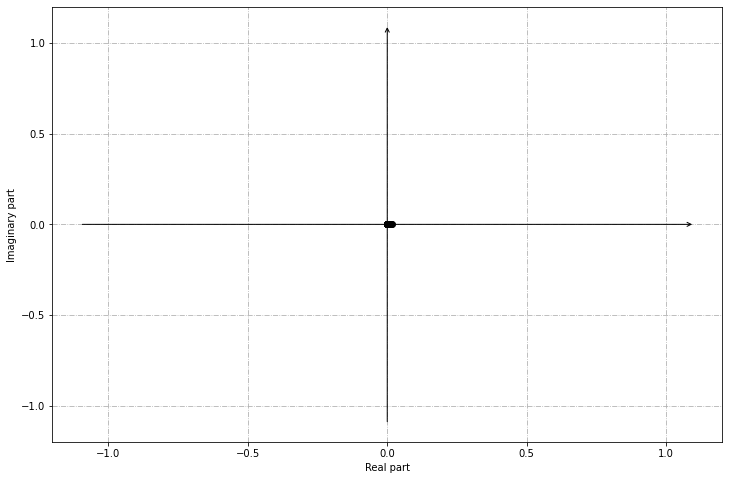

In [16]:
spod.plot_eigs()

We can then plot the **eigenvalues as a function of frequency and period** (note that we multiply the frequency by 24, that is the number of hours in a day, to obtain a period for the x-axis in days). Again, we can see how thorough the `PySPOD` object returned after the computation we can access the frequency array (`spod.freq`) along with the plotting methods `spod.plot_eigs_vs_frequency` and `spod.plot_eigs_vs_period`.

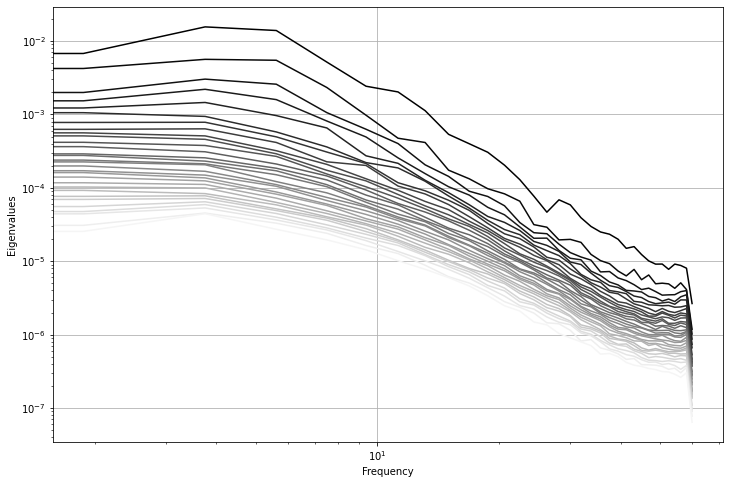

In [17]:
freq = spod.freq*24
spod.plot_eigs_vs_frequency(freq=freq)

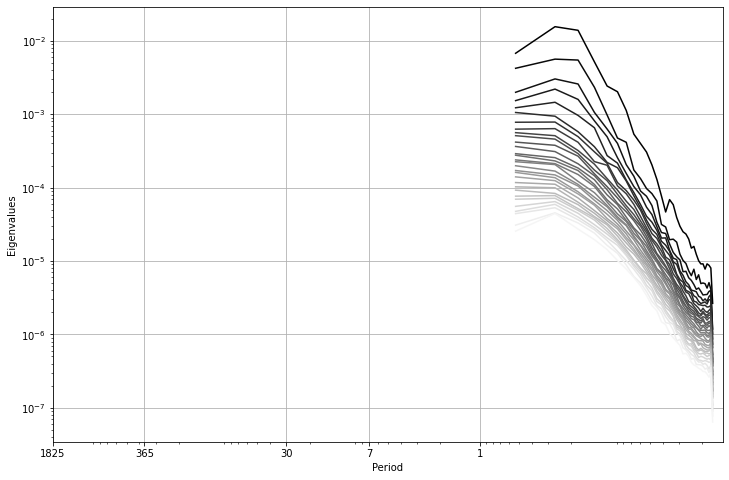

In [18]:
spod.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])

We can then plot the **modes** that were computed by the SPOD algorithm via the built-in `plot_2D_modes_at_frequency` method, that can again be accessed via the `PySPOD` object returned after the computation. To this method, we pass the frequency of the modes we are interested in. This corresponds to the frequency associated to the T_approx of 876 days that we requested, and stored in the variable `freq_found` that we calculated above. Note that we also pass the `vars_idx` corresponding to the variable we are interested in, modes_idx corresponding to the modes we are interested in, as well as `x1`, and `x2`, that correspond to longitude and latitude. 

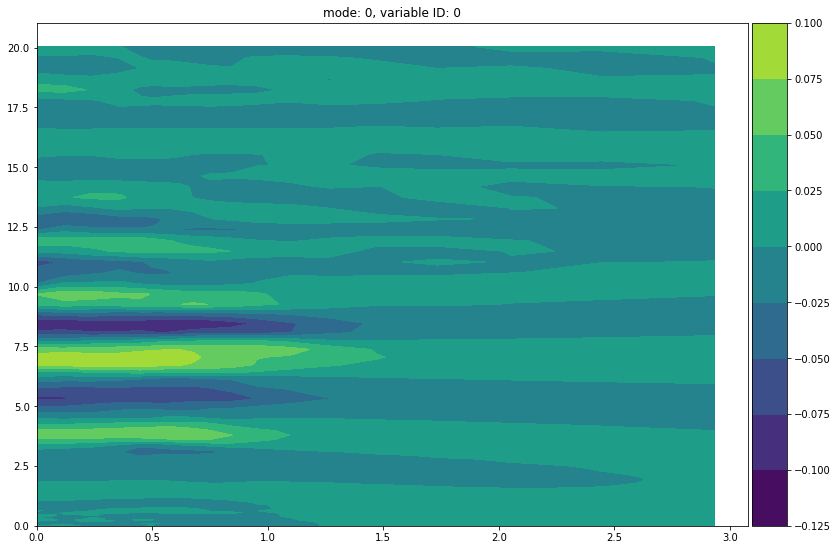

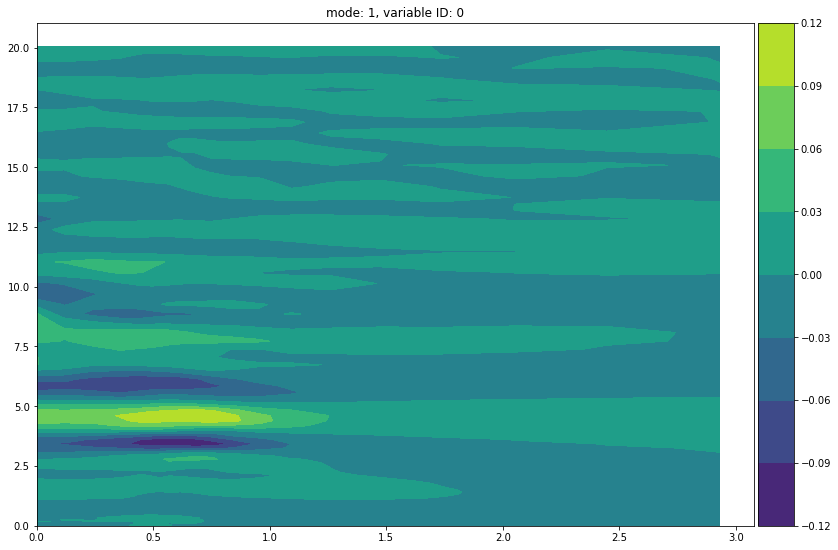

In [19]:
spod.plot_2D_modes_at_frequency(
	freq_required=freq_found, freq=freq, x1=x1, x2=x2, modes_idx=[0,1], vars_idx=[0])

Note that we can also plot the **original data** by

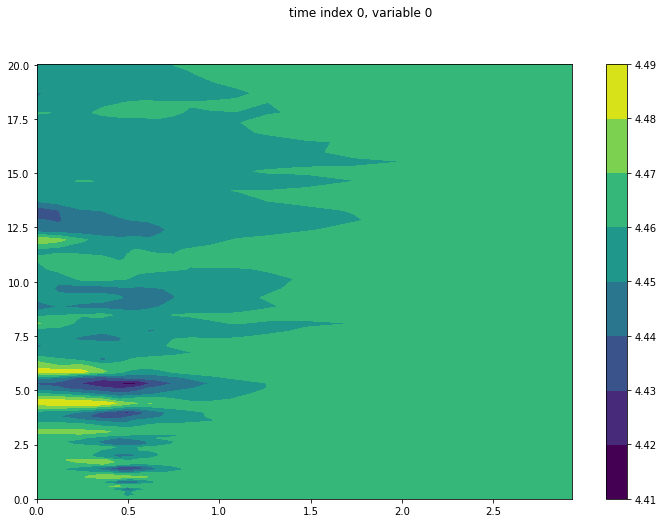

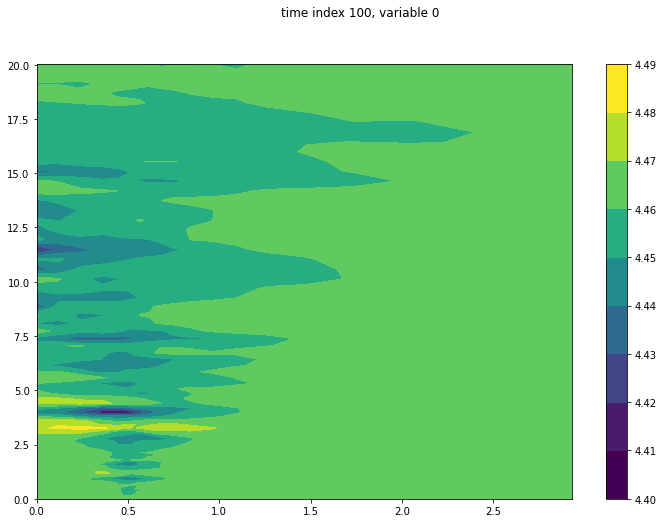

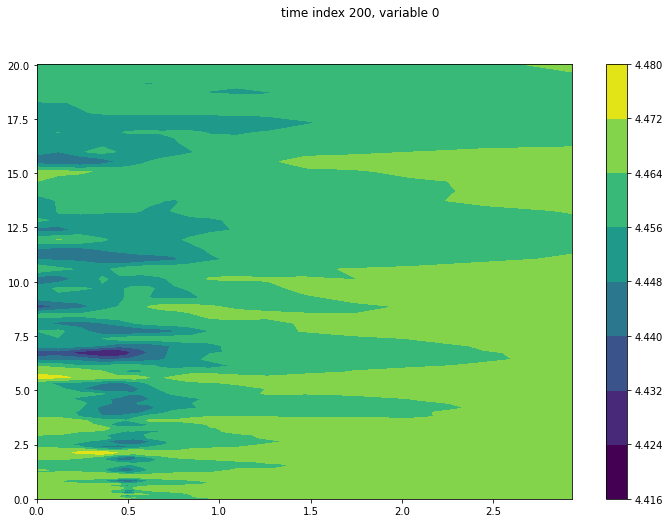

In [20]:
spod.plot_2D_data(x1=x1, x2=x2, vars_idx=[0], time_idx=[0,100,200])

Along with a video of the original data

In [21]:
spod.generate_2D_data_video(x1=x1, x2=x2, vars_idx=[0])

## Final notes

The results are stored in the results folder defined in the parameter you specified under `params[savedir]`. We can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exists several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to you specific post-processing pipeline.

This tutorial was intended to help you setup your own multivariate case. You can play with the parameters we explored above to gain more insights into the capabilities of the library. You can also run on the same data the other two SPOD algorithms implemented as part of this library by simply calling:
- SPOD_analysis = SPOD_low_ram(X=X, params=params, file_handler=False)
- SPOD_analysis = SPOD_streaming(X=X, params=params, file_handler=False)

and compare the results.